## Tutorial 10, Question 2c (Sparsity)

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

In [2]:
# Set random seed for reproducibility
seed = 10
torch.manual_seed(seed)
np.random.seed(seed)

# Create a figures directory if it doesn't exist
if not os.path.isdir('figures'):
    os.makedirs('figures')

# Parameters
n_hidden = 144

In [3]:
# Create 100 images with size 10*10
X = np.random.rand(100, 10*10)

# Convert numpy arrays to torch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)

## Defining the Autoencoder Class

In the code provided, we are defining a simple autoencoder using PyTorch. Here's a breakdown of its structure and functionality:

### Class Initialization

- The `Autoencoder` class inherits from `nn.Module`, which is a standard practice when defining any neural network model in PyTorch.

- Within the `__init__` method, we define the architecture of our autoencoder. It consists of two main parts: the encoder and the decoder.

    - `self.encoder`: This is a linear layer that reduces the dimensionality of the input data, compressing it into a lower-dimensional space. The layer's size is defined by `n_input` (the size of the input data) and `n_hidden` (the size of the compressed representation).
    
    - `self.decoder`: Another linear layer that reconstructs the original data from its compressed form. The layer's size is the reverse of the encoder, defined by `n_hidden` and `n_input`, respectively.

- The weights of the neural network are initialized following a specific strategy:

    - For the encoder, we initialize the weights with a normal distribution with a mean of `0.0` and a standard deviation of `1 / np.sqrt(n_input)`. This specific choice helps in stabilizing the learning process by controlling the variance of the weights.
    
    - For the decoder, we are using a technique called "tied weights," where the decoder's weights are the transpose of the encoder's weights (`self.encoder.weight.data.T`). This not only reduces the number of parameters in the model but also imposes a form of regularization.

### Forward Pass

- The `forward` method defines the sequence of operations the model performs to generate an output from an input.

    - The input data `x` is first passed through the encoder, compressed, and then the sigmoid activation function is applied. The sigmoid function ensures the output is in the range (0, 1), making the model's behavior more predictable and the learning process more stable.
    
    - The compressed data is then passed through the decoder, attempting to reconstruct the original input. Again, the sigmoid activation function is applied to the output.

- The final output is the activation and the reconstructed data.

### Model Instantiation

- Finally, we create an instance of the `Autoencoder` class with `28*28` input size (typical for MNIST images, which are 28x28 pixels) and `n_hidden` representing the size of our hidden (compressed) layer. This instance `model` is what we will train and use for encoding/decoding tasks.


In [4]:
# Model
class Autoencoder(nn.Module):
    def __init__(self, n_input, n_hidden):
        super(Autoencoder, self).__init__()
        # Linear function
        self.encoder = nn.Linear(n_input, n_hidden)
        self.decoder = nn.Linear(n_hidden, n_input)

        # Weight initialization
        self.encoder.weight.data.normal_(0.0, 1 / np.sqrt(n_input))
        self.decoder.weight.data = self.encoder.weight.data.T  # tied weights

    def forward(self, x):
        h = torch.sigmoid(self.encoder(x))
        x = torch.sigmoid(self.decoder(h))
        return h,x

model = Autoencoder(10*10, n_hidden)

In [5]:
def loss_function(h, y, original):
    rho = 0.05

    # Calculate the mean squared error (MSE) loss
    mse_loss = torch.mean(torch.sum((original - y) ** 2, dim=1))

    # Calculate the sparse loss
    mean_h = torch.mean(h, dim=0)
    sparse_loss = torch.sum(rho * torch.log(rho / mean_h) + (1 - rho) * torch.log((1 - rho) / (1 - mean_h)))

    return mse_loss + 0.5 * sparse_loss

In [6]:
# DataLoader for batch processing
batch_size = 32
train_data = TensorDataset(X_tensor)
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

# Optimizer
learning_rate = 0.1
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

In [7]:
# Training function
def train(model, dataloader, loss_fn, optimizer):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(dataloader):
        optimizer.zero_grad()
        inputs = data[0]
        activations, outputs = model(inputs)
        loss = loss_fn(activations, outputs, inputs)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    average_loss = running_loss / len(dataloader)
    return average_loss

# Main function: train the model
no_epochs = 1000
print('Training starts...')
loss_history = []
for epoch in range(no_epochs):
    epoch_loss = train(model, train_loader, loss_function, optimizer)
    loss_history.append(epoch_loss)
    if epoch % 100 == 0:
        print('epoch: %d, total_loss: %f' % (epoch, epoch_loss))

Training starts...
epoch: 0, total_loss: 29.608338
epoch: 100, total_loss: 7.729981
epoch: 200, total_loss: 6.885895
epoch: 300, total_loss: 5.426512
epoch: 400, total_loss: 4.261046
epoch: 500, total_loss: 3.502199
epoch: 600, total_loss: 2.925949
epoch: 700, total_loss: 2.611675
epoch: 800, total_loss: 2.290336
epoch: 900, total_loss: 2.162490


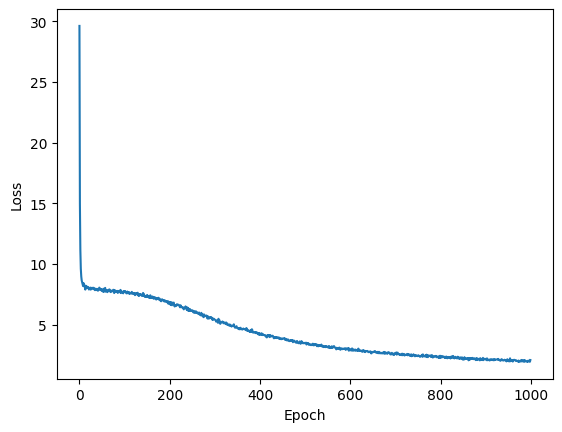

In [9]:
# Plotting the training loss
plt.figure()
plt.plot(loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.savefig('./figures/t10q2c_1.png')

<ipython-input-10-ba16af529ca8>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images = torch.tensor(images, dtype=torch.float32)
<ipython-input-10-ba16af529ca8>:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images = torch.tensor(images, dtype=torch.float32)


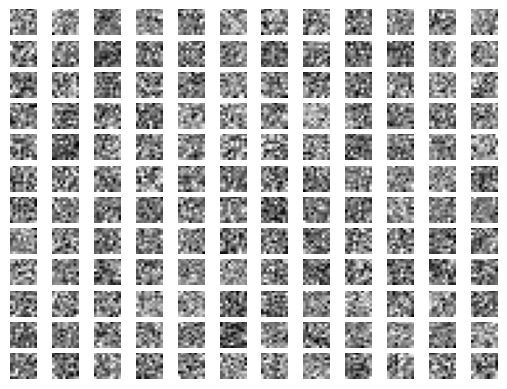

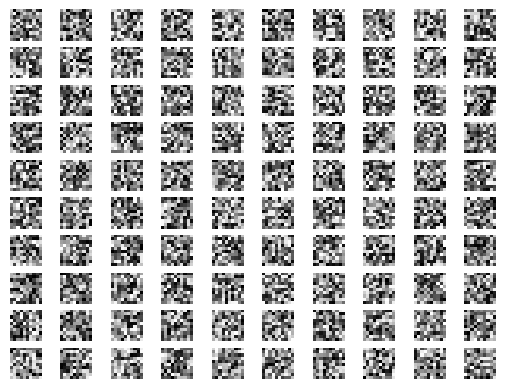

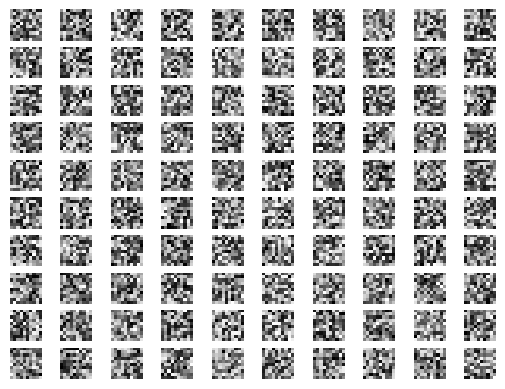

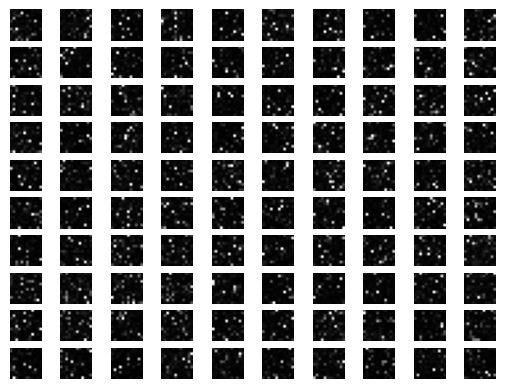

In [10]:
# Function to visualize the weights of the first layer
def visualize_weights(model):
    # Extract weights from the first layer (encoder)
    weights = model.encoder.weight.data.numpy()
    plt.figure()
    plt.gray()
    for i in range(144):
        plt.subplot(12, 12, i+1)
        plt.axis('off')
        plt.imshow(weights[i].reshape(10, 10))
    plt.savefig('./figures/t10q2c_2.png')

# Function to visualize the original images
def visualize_images(images):
    plt.figure()
    plt.gray()
    for i in range(100):
        plt.subplot(10, 10, i+1)
        plt.axis('off')
        plt.imshow(images[i].reshape(10, 10))
    plt.savefig('./figures/t10q2c_3.png')

# Function to visualize the reconstructions
def visualize_reconstructions(model, images):
    plt.figure()
    plt.gray()
    images = torch.tensor(images, dtype=torch.float32)
    _, reconstructions = model(images)
    reconstructions = reconstructions.detach().numpy()
    for i in range(100):
        plt.subplot(10, 10, i+1)
        plt.axis('off')
        plt.imshow(reconstructions[i].reshape(10, 10))
    plt.savefig('./figures/t10q2c_4.png')

# Function to visualize the hidden layer activations
def visualize_activations(model, images):
    plt.figure()
    plt.gray()
    images = torch.tensor(images, dtype=torch.float32)
    activations, _ = model(images)
    activations = activations.detach().numpy()
    for i in range(100):
        plt.subplot(10, 10, i+1)
        plt.axis('off')
        plt.imshow(activations[i].reshape(12, 12))
    plt.savefig('./figures/t10q2c_5.png')

# Call the visualization functions
visualize_weights(model)
visualize_images(X)
visualize_reconstructions(model, X_tensor)
visualize_activations(model, X_tensor)

# Display figures
plt.show()